#Mask R-CNN instance segmentation with custom dataset in Google Colab
Jupyter notebook providing steps to train a **Matterport Mask R-CNN** model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com/) using [Matterport framework](https://github.com/matterport/Mask_RCNN) with TensorFlow backend.

**Requirements are only dataset images and annotations file.**

**Colab Runtime type: Python3, GPU enabled.**

#Making Dataset
I generated dataset annotations with [VGG Image Annotator](http://www.robots.ox.ac.uk/~vgg/software/via/).

Notebook train a model for one class object detection. It is possible to slightly modify notebook to train model for multiple classes.

Before running notebook, we need to create dataset:


1.   Collect various pictures of objects to detect
3.   Create annotation files in VGG
4.   Create image.zip file having structure defined below
5.   Upload the zip file in your Google Drive

Zip file structure:
```
images.zip
|- "train" directory
  |- jpg image files of training data
  |- "via_region_data.json" annotations file of training data
|- "val" directory
  |- jpg image files of validation data
  |- "via_region_data.json" annotations file of validation data
```
Check my image.zip file as dataset example.

#Install required packages

In [1]:
%cd
  
!git clone --quiet https://github.com/hmc0105/Mask_RCNN

/root


In [2]:
%cd ~/Mask_RCNN
!pip3 install keras==2.2.5
!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

/root/Mask_RCNN
     |████████████████████████████████| 337kB 7.9MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 163kB 9.1MB/s 
     |████████████████████████████████| 204kB 14.5MB/s 
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/u

#Download and extract dataset
Update fileId variable with Google Drive id of your image.zip dataset


In [3]:
%cd ~/Mask_RCNN


fileId = '1XIqZwpaYSw4SHCkCVYkaGpiYfl8htmxH'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('dataset')
os.chdir('dataset')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/root/Mask_RCNN
Extracted zip file 1XIqZwpaYSw4SHCkCVYkaGpiYfl8htmxH.zip


#Edit settings file
*  find and replace occurrences of "balloon" and "Balloon" with name of your object
*  set epochs number


In [24]:
%cd ~/Mask_RCNN
%tensorflow_version 1.x
!cp ~/Mask_RCNN/samples/balloon/balloon.py ./facial_mask.py

!sed -i -- 's/balloon/facial_mask/g' facial_mask.py
!sed -i -- 's/Balloon/Facial_mask/g' facial_mask.py
!sed -i -- 's/epochs=30/epochs=20/g' facial_mask.py

/root/Mask_RCNN


In [5]:
!pip3 install keras==2.2.5

  Using cached https://files.pythonhosted.org/packages/f8/ba/2d058dcf1b85b9c212cc58264c98a4a7dd92c989b798823cc5690d062bb2/Keras-2.2.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


#Train model
Pretrained weights options are COCO, ImageNet or a model trained before

In [ ]:
!pwd

/root/Mask_RCNN


In [28]:
%cd ~/Mask_RCNN

!python facial_mask.py train --dataset=dataset/ --weights=coco

/root/Mask_RCNN
Using TensorFlow backend.
Weights:  coco
Dataset:  dataset/
Logs:  /logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.2
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss':

#Run inference on test dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [26]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import facial_mask

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

custom_WEIGHTS_PATH = sorted(glob.glob("/logs/*/mask_rcnn_*.h5"))[-1]
#custom_WEIGHTS_PATH="/content/drive/MyDrive/project/Mask-RCNN/Facial_mask_best.h5"
#custom_WEIGHTS_PATH="/logs/facial_mask20201127T1414/mask_rcnn_facial_mask_0010.h5"
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

config = facial_mask.Facial_maskConfig()
custom_DIR = "/root/Mask_RCNN/dataset"
#custom_DIR='/content'
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  
# Load validation dataset
dataset = facial_mask.Facial_maskDataset()
dataset.load_facial_mask(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# load the last model you trained
# weights_path = model.find_last()[1]
# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

graph = tf.get_default_graph()





Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

image ID: facial_mask.1.png (0) /root/Mask_RCNN/dataset/val/1.png
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  141.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   77.00000  max:  222.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool
image ID: facial_mask.2.png (1) /root/Mask_RCNN/dataset/val/2.png
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  ma

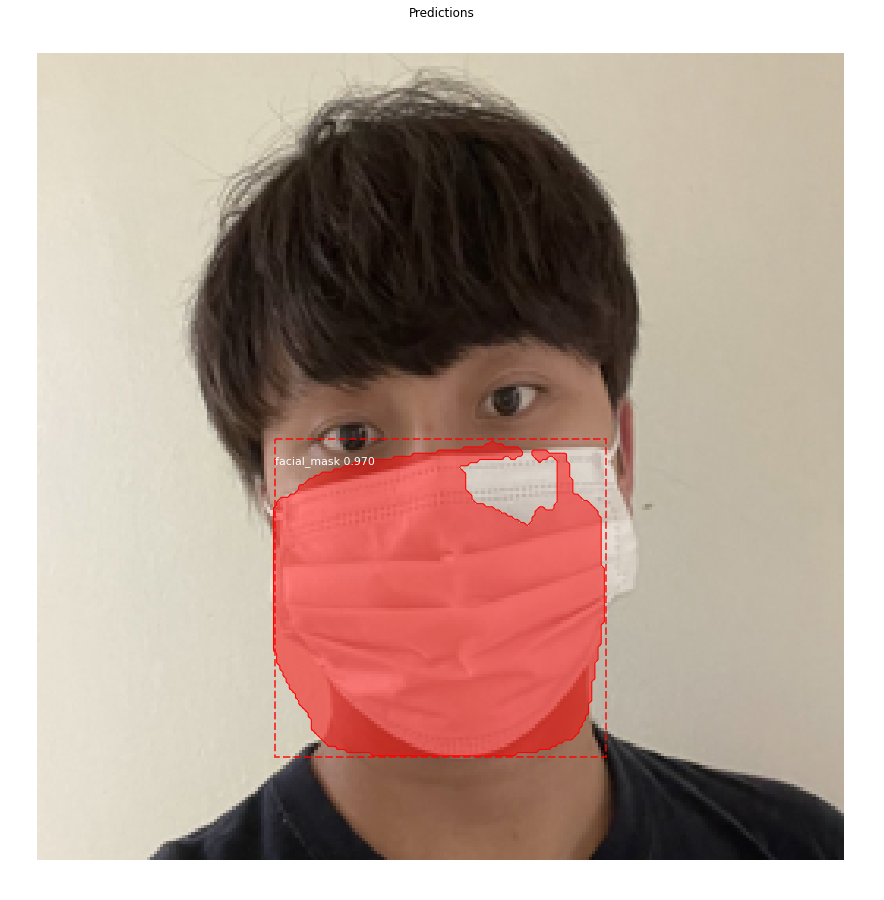

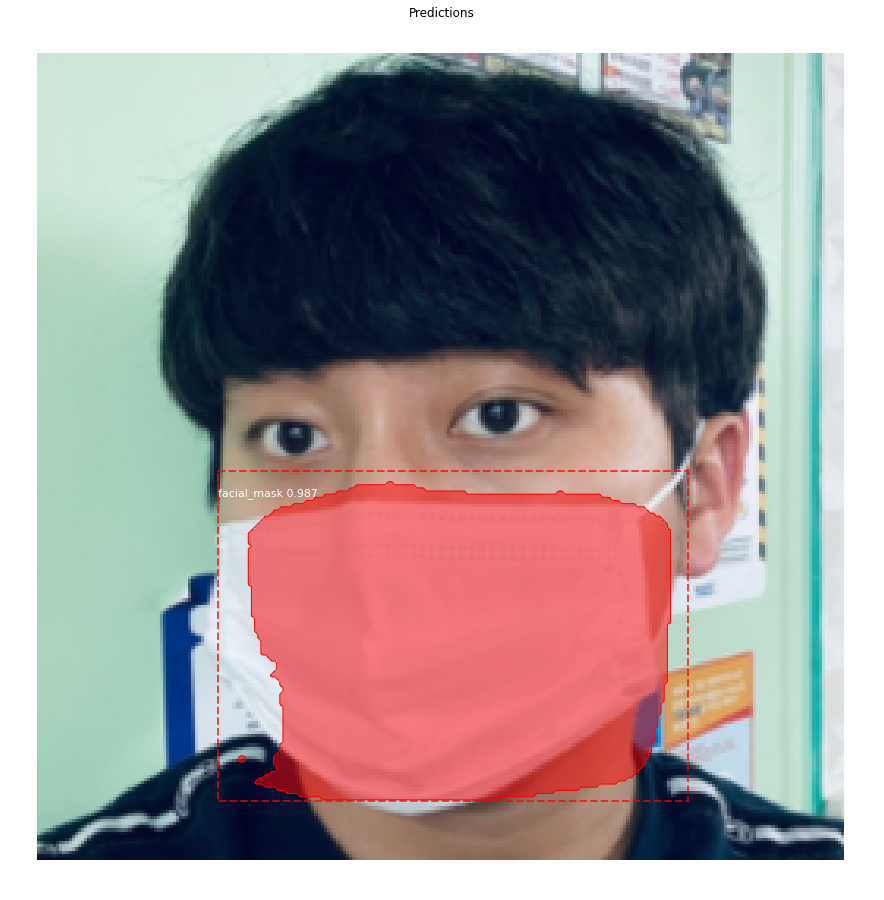

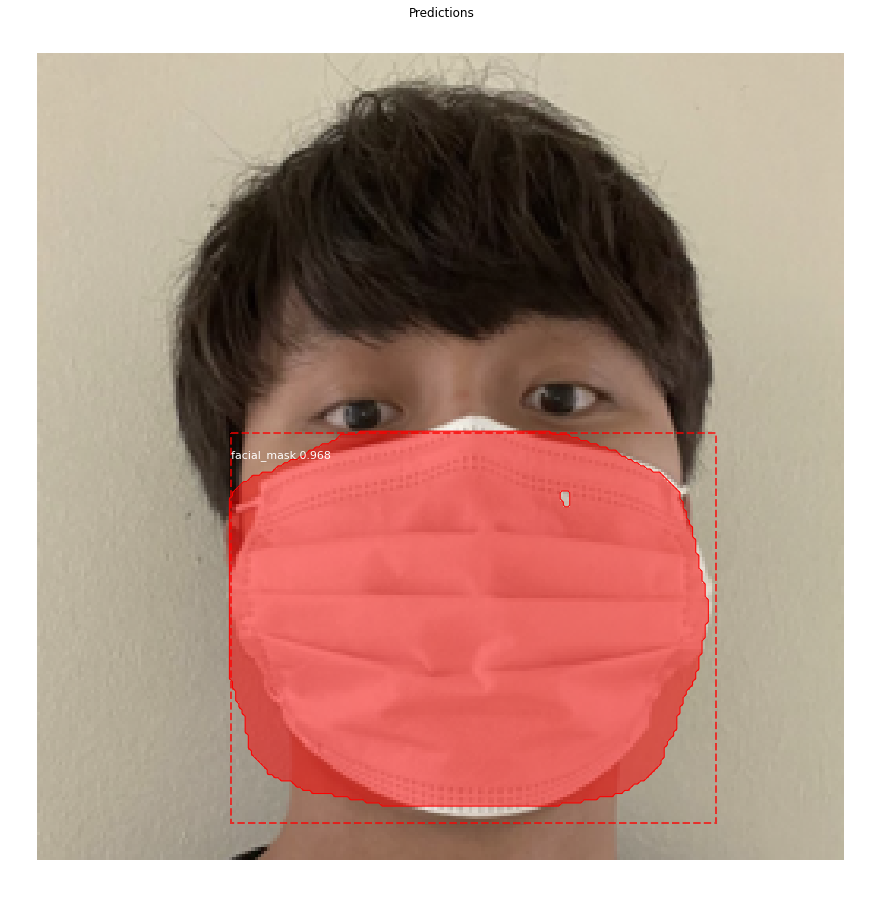

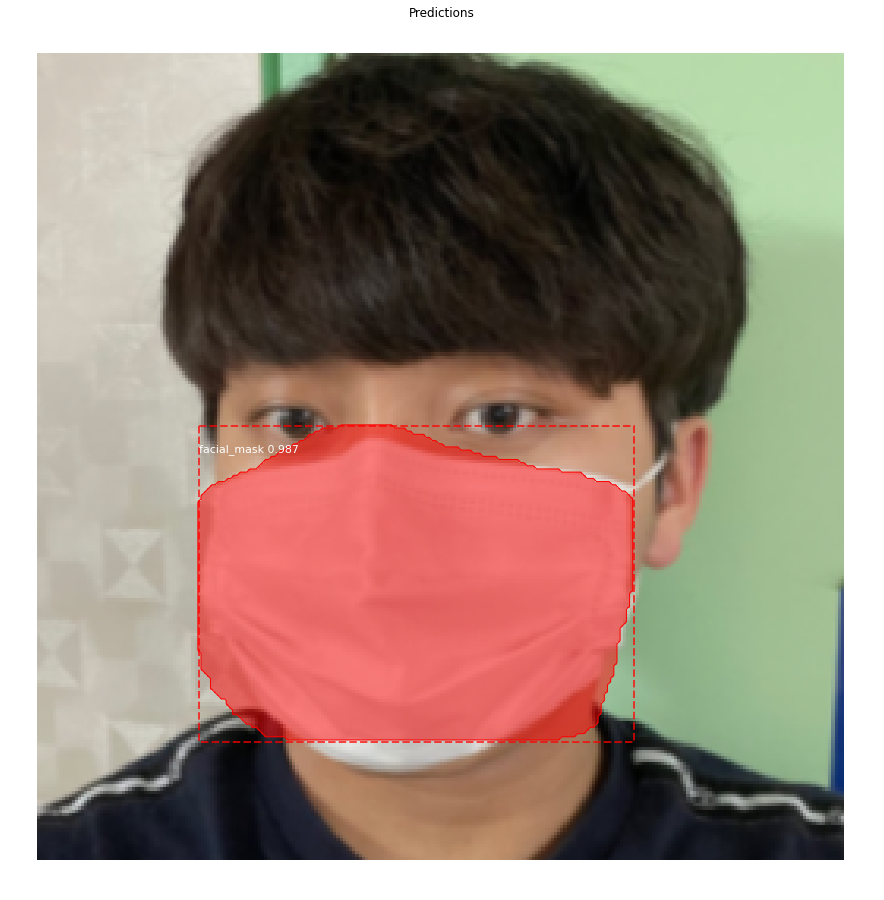

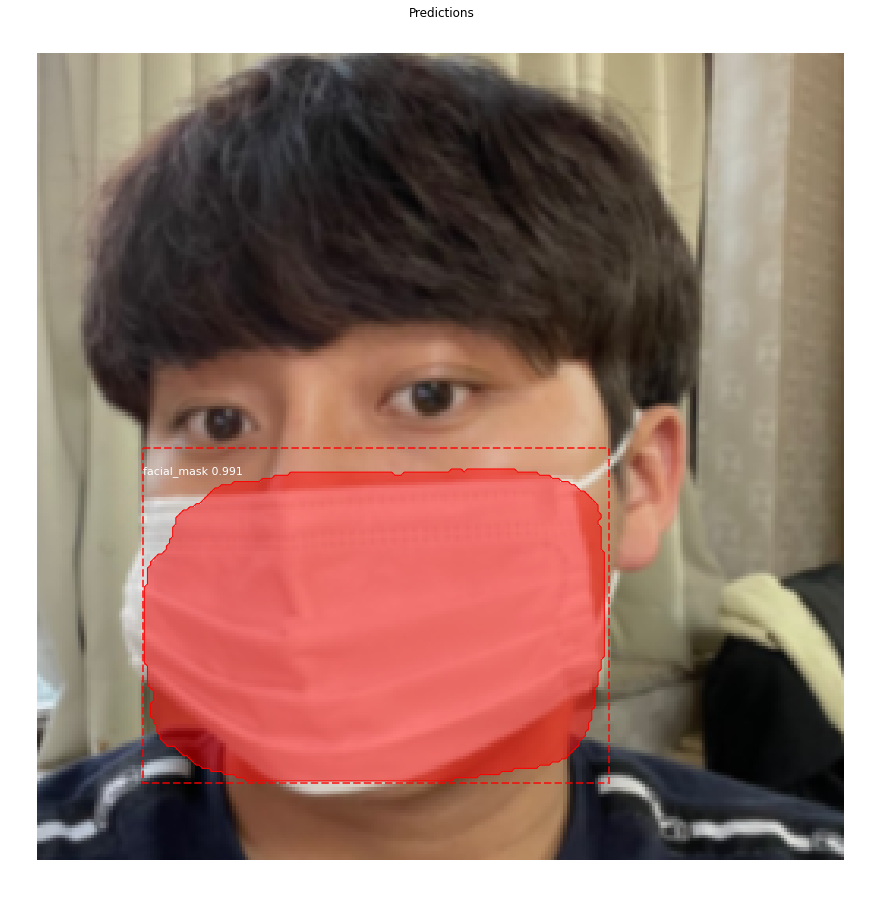

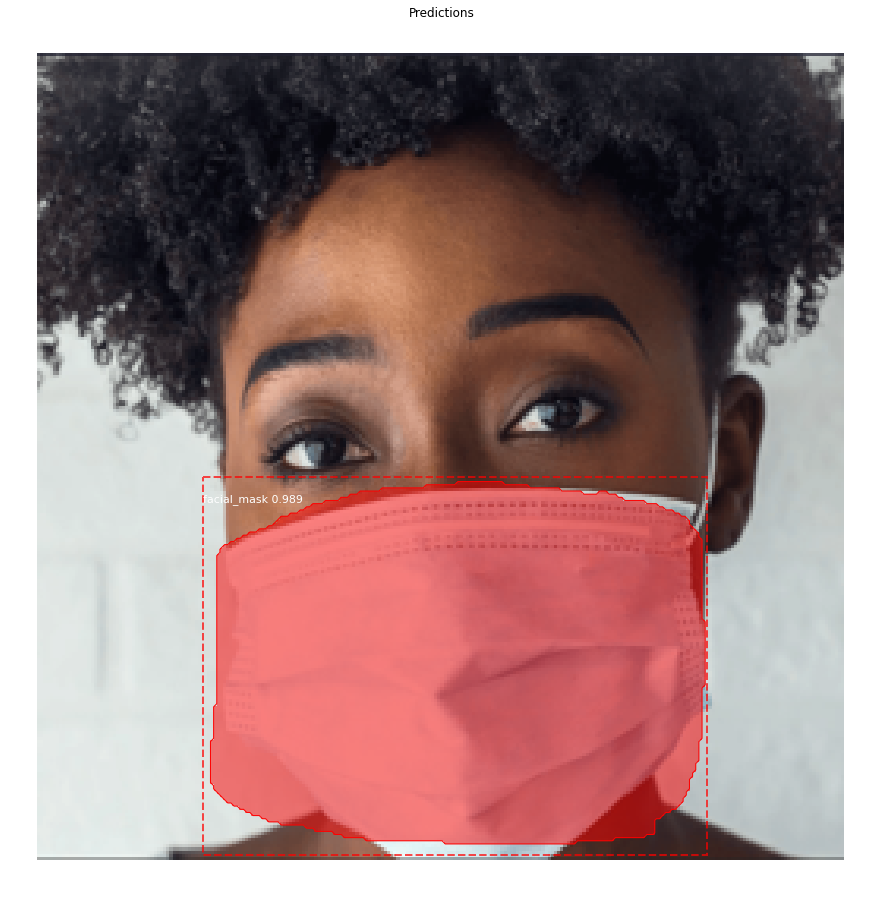

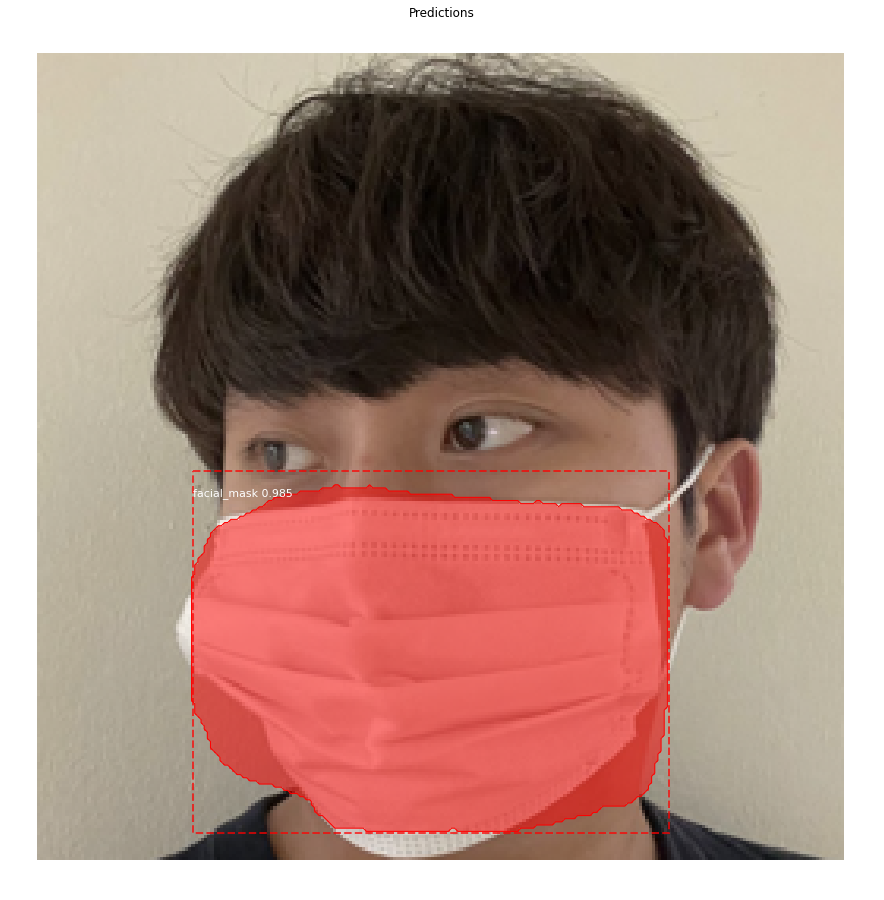

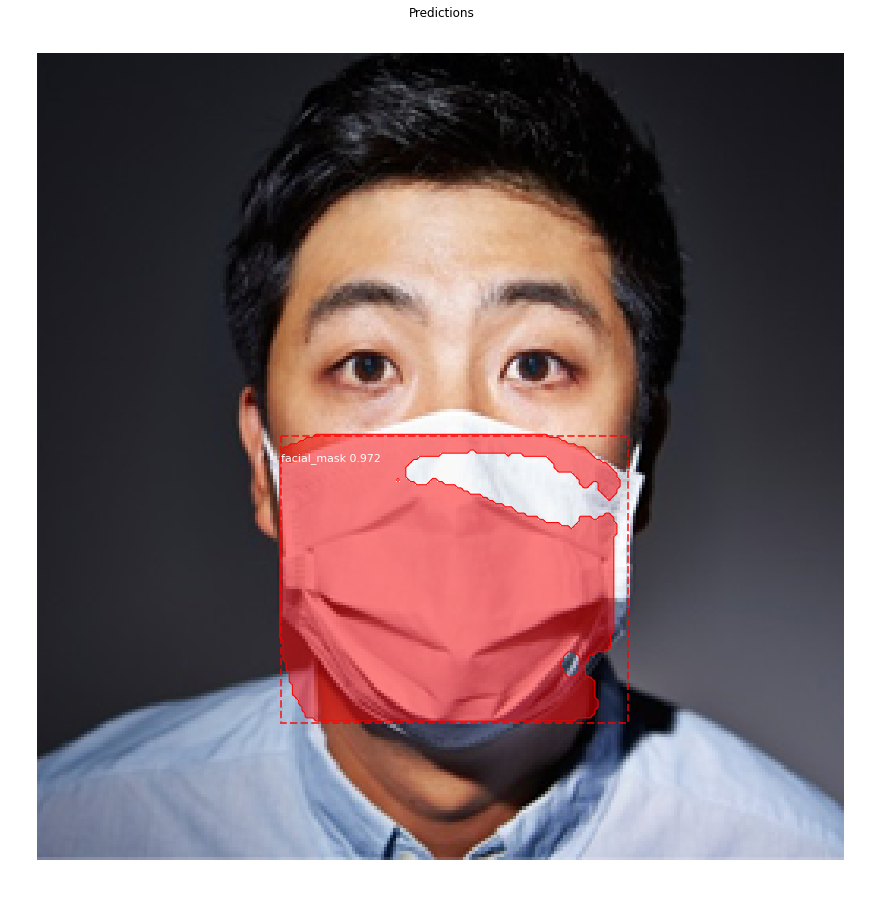

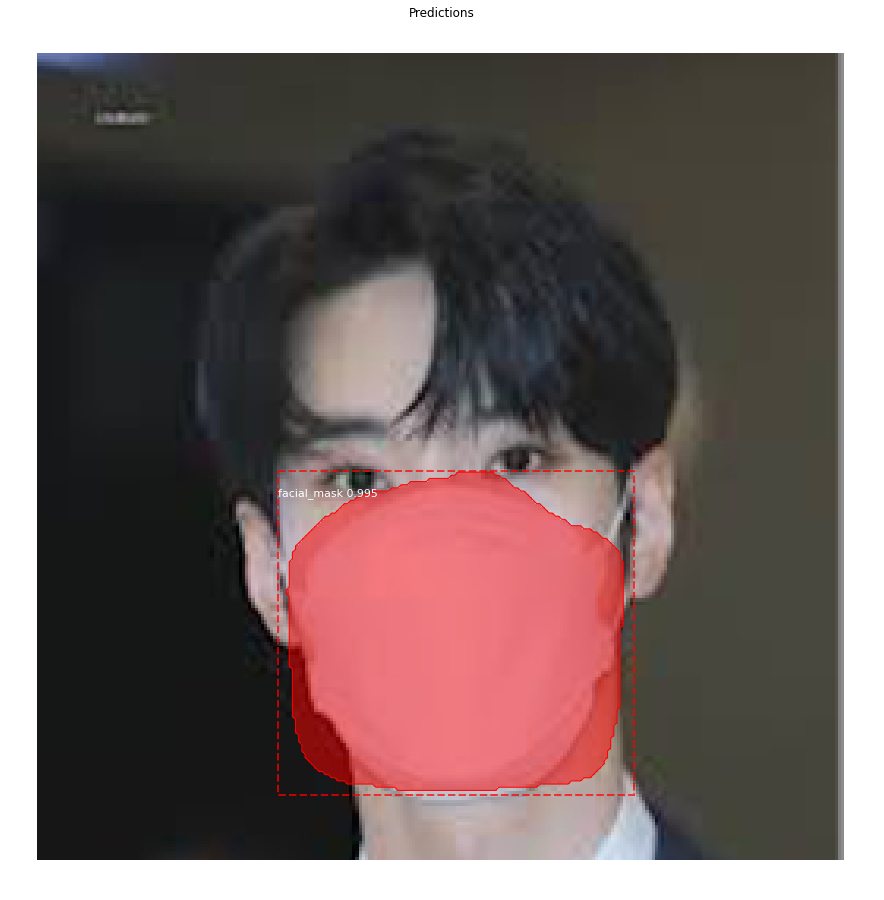

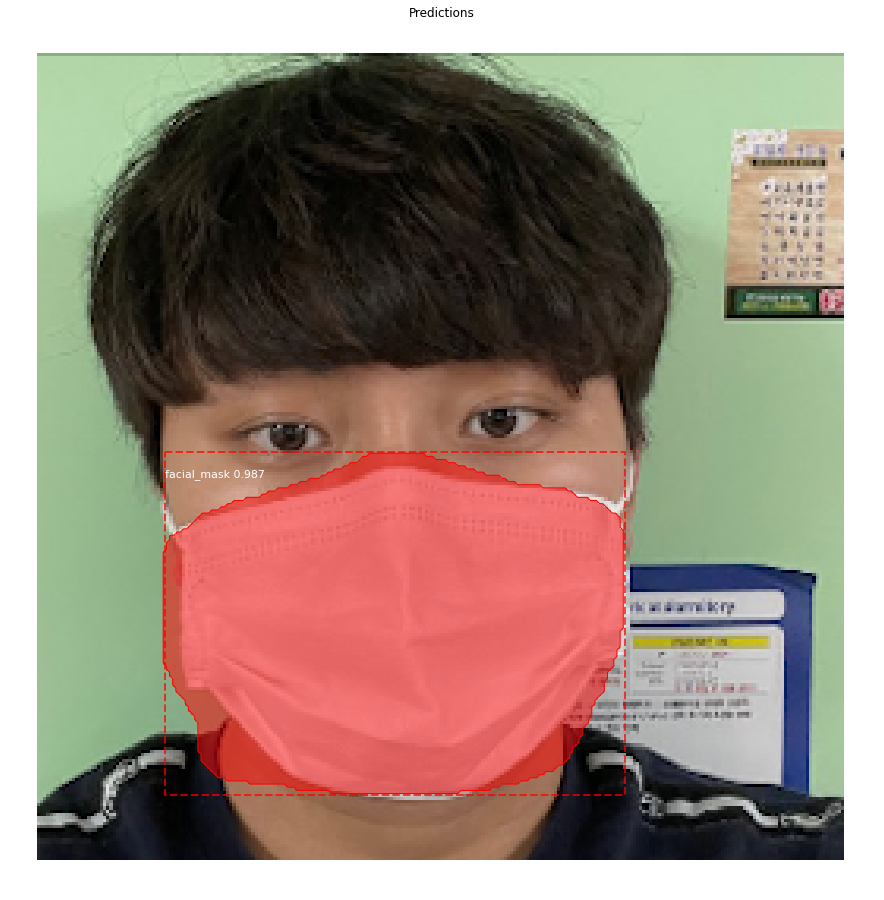

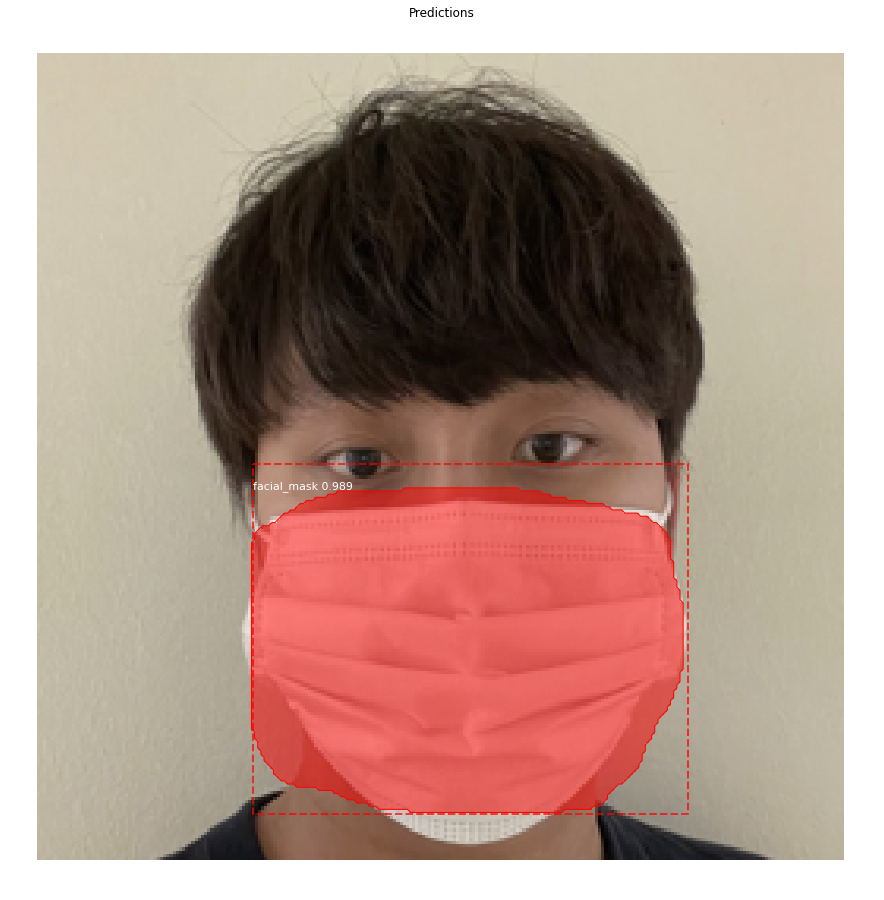

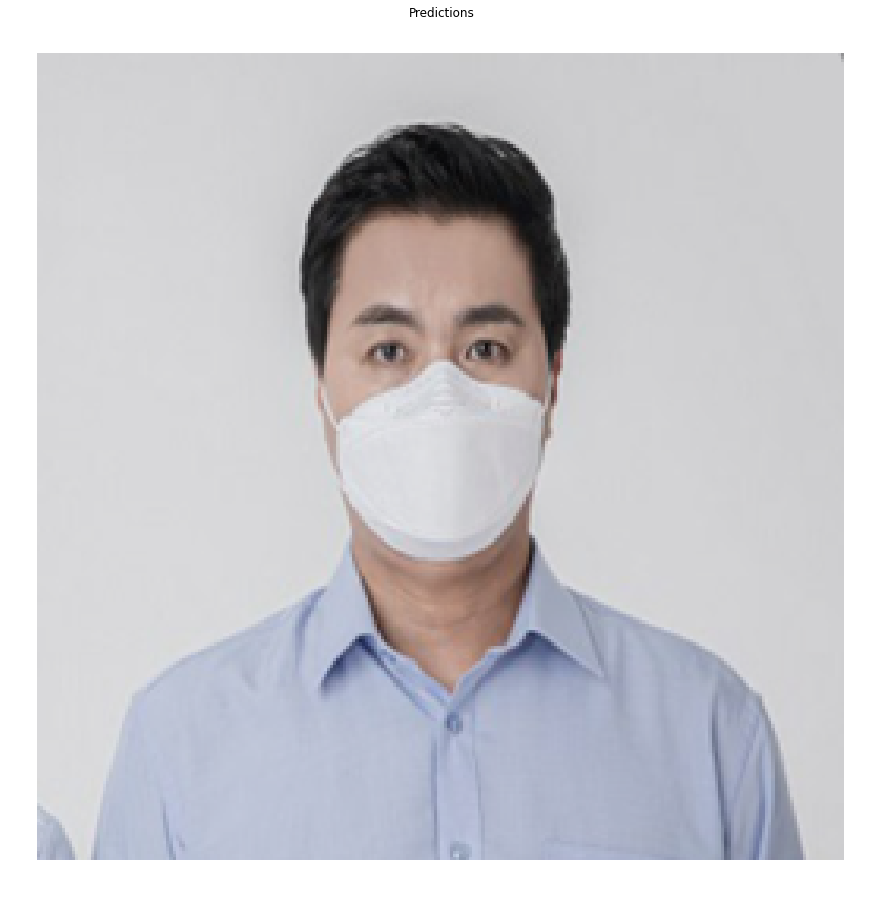

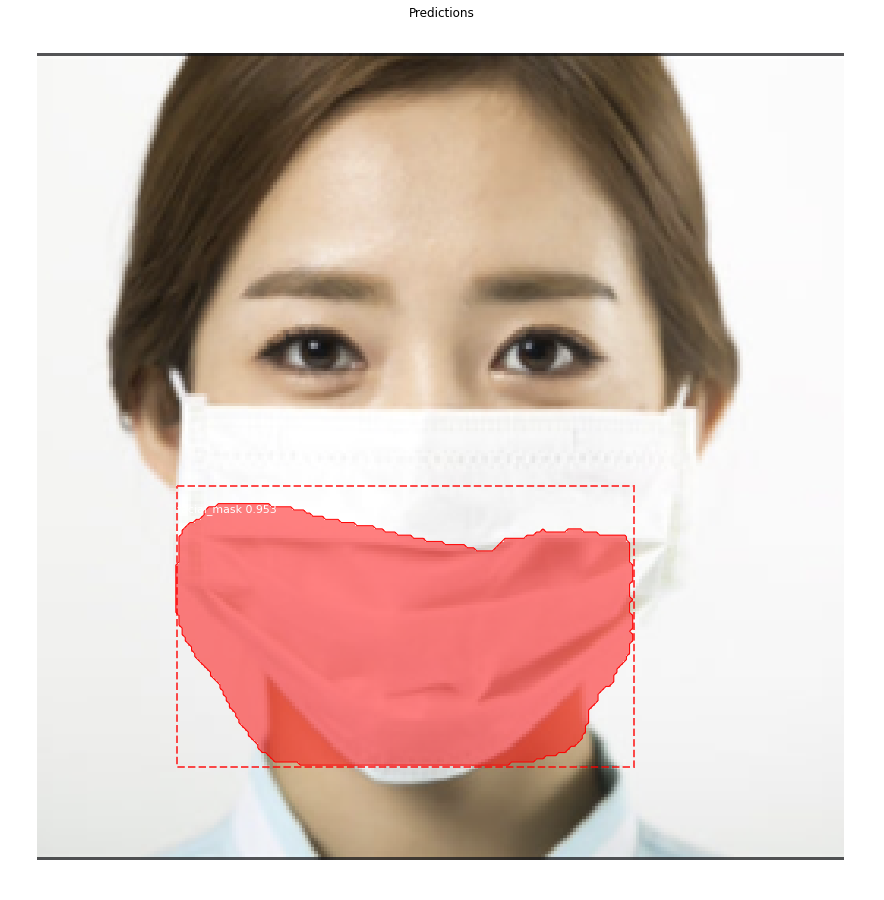

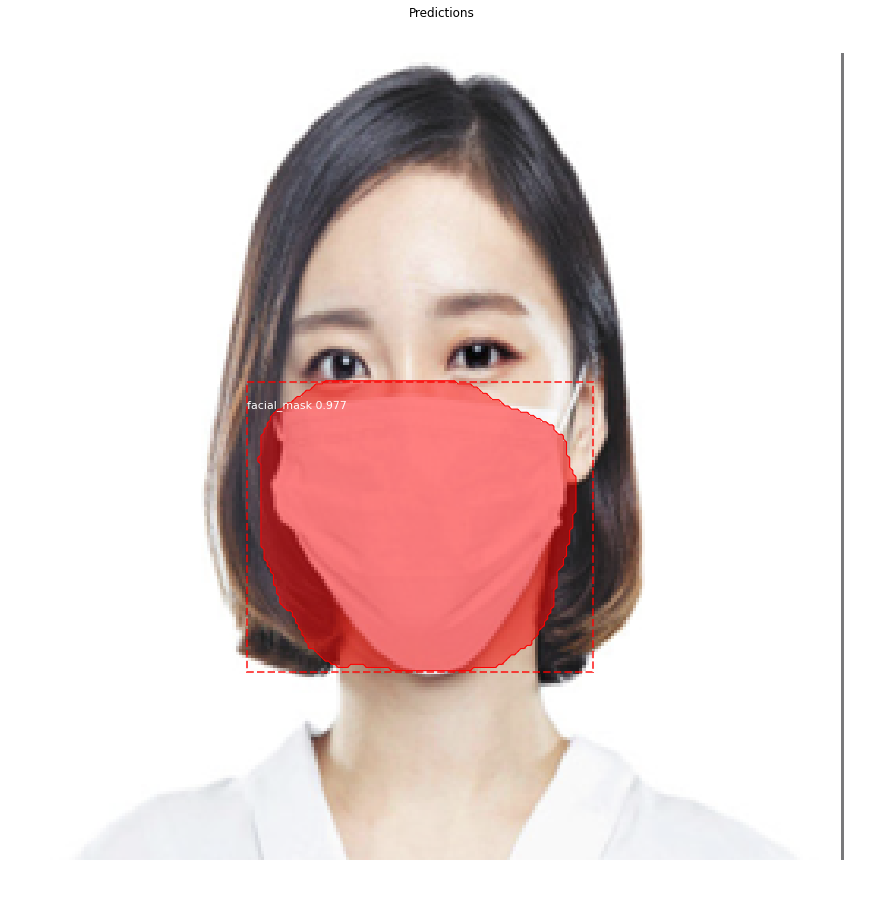

In [30]:
image_id = random.choice(dataset.image_ids)
from PIL import Image
import numpy
APs=[]
i=0
for image_id in dataset.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
  info = dataset.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                         dataset.image_reference(image_id)))
  #pic=Image.open("/content/img_0624.jpg")
  #if pic.getdata().mode == "RGBA":
        #pic= pic.convert('RGB')
  #image = numpy.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
  #np.transpose(image,(1,0,2))
  # Run object detection
  results = model.detect([image], verbose=1)

  # Display results
  ax = get_ax(1)
  r = results[0]
  AP, precisions, recalls, overlaps =\
    utils.compute_ap(gt_bbox,gt_class_id,gt_mask,r["rois"],r["class_ids"],r["scores"],r["masks"],0.7)
  APs.append(AP)
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              dataset.class_names, r['scores'], ax=ax,
                              title="Predictions")
  log("gt_class_id", gt_class_id)
  log("gt_bbox", gt_bbox)
  log("gt_mask", gt_mask)
  i+=1
  size=(256,256)
  mask_result=r['masks']
  mask_image=Image.new("RGB",size)
  pixels = mask_image.load()
  #for i in range(size[0]):
  #  for j in range(size[1]):
  #    if(mask_result[i,j]==1):
  #      pixels[j,i]=(255,255,255)
  #mask_image.save("/content/hello/"+info["id"])
print(APs)
print("mAP: ", np.mean(APs))

In [ ]:
%cd /content/hello 